In [1]:
nevecs = 60
ncomps = 500
nbasecomps = 20
crop_size=180
ncauses = 2
dr_method = 'PCA'

In [2]:
from pathlib import Path
import os, sys

In [3]:

macaw_path = Path(os.getcwd())
sys.path.append(str(macaw_path) +'/')

exp_name = 'no_bias'

train_csv_path = macaw_path/'splits'/'train.csv'
train_img_path = macaw_path/'no_bias'/'train'

# test_csv_path = macaw_path/'data'/'ukbb'/'test_hc.csv'
# test_img_path = macaw_path/'data'/'ukbb'/'axial'/'test_hc'
# 
pca_path = macaw_path/exp_name/f'train_hc_pca_{ncomps}.pkl'
# 
train_path = macaw_path/exp_name/f'train_hc_data_PCA_{ncomps}.pkl'
# test_path = macaw_path/'data'/'ukbb'/'axial'/f'test_hc_data_PCA_{ncomps}.pkl'
model_base_path = macaw_path/'models'/exp_name/f'{dr_method}_{ncomps}'/f'{nevecs}'

if not os.path.exists(model_base_path):
    os.makedirs(model_base_path)

In [4]:
import pickle

with open(train_path, 'rb') as f:
    train = pickle.load(f)
    
disease = train['disease']
bias = train['bias']

encoded_data = train['encoded_data']
pca = train['pca']

In [5]:
encoded_data.shape

(1005, 500)

In [6]:
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import numpy as np

/home/volatope/Software/anaconda3/lib/python3.11/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/volatope/Software/anaconda3/lib/python3.11/site-packages/torch/cuda/__init__.py:749: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count


[Text(0.5, 1.0, 'disease')]

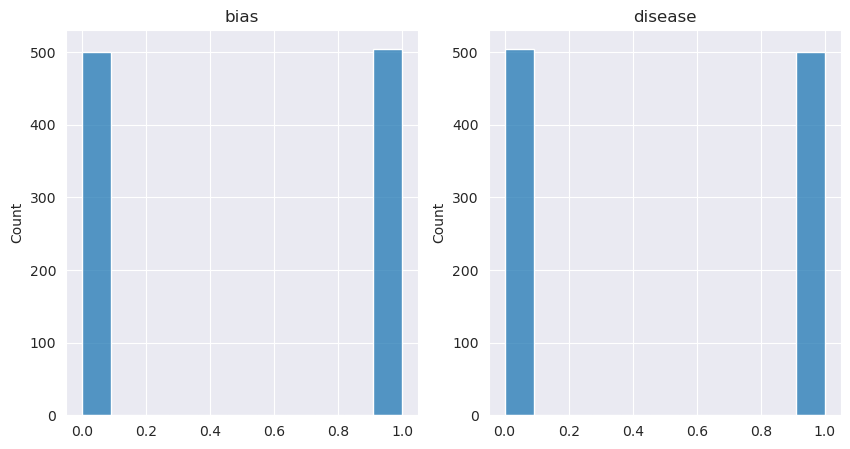

In [7]:
import seaborn as sns

sb = 2
fig, axs = plt.subplots(1,sb, figsize=(sb*5,5))

sns.histplot(bias,ax=axs[0],fill=True)
axs[0].set(title = "bias")
sns.histplot(disease,ax=axs[1], fill=True)
axs[1].set(title="disease")
# sns.histplot(encoded_data[0],ax=axs[3], fill=True)
# axs[3].set(title="PCA0")

## Causal Graph

In [8]:
disease_to_latents = [(0,i) for i in range(ncauses,nevecs+ncauses)]

bias_to_latents = [(1,i) for i in range(ncauses,nevecs+ncauses)]

autoregressive_latents = [(i,j) for i in range(ncauses,nevecs+ncauses) for j in range(i+1,nevecs+ncauses)]
# autoregressive_latents = [(i,j) for i in range(ncauses,2*ncauses) for j in range(i+1,nevecs+ncauses)]
# autoregressive_latents = []
edges = disease_to_latents + bias_to_latents + autoregressive_latents

## Priors

In [9]:
P_bias = np.sum(bias)/len(bias)
print(P_bias)

P_dis = np.sum(disease)/len(disease)
print(P_dis)

0.5024875621890548
0.4975124378109453


In [10]:
import torch
import yaml
from utils.helpers import dict2namespace

with open(macaw_path/'config'/'ukbb.yaml', 'r') as f:
    config_raw = yaml.load(f, Loader=yaml.FullLoader)
    
config = dict2namespace(config_raw)
config.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [11]:
torch.cuda.is_available()

False

In [12]:
config.device

device(type='cpu')

In [13]:
import torch.distributions as td

dev='cpu'

priors = [(slice(0,1),td.Bernoulli(torch.tensor([P_bias]).to(torch.device(dev)))), # bias
          (slice(1,2),td.Bernoulli(torch.tensor([P_dis]).to(torch.device(dev)))), # disease
          (slice(nbasecomps+2,nevecs+2),td.Normal(torch.zeros(nevecs-nbasecomps).to(torch.device(dev)), torch.ones(nevecs-nbasecomps).to(torch.device(dev)))), # new_comps
         ]

In [14]:
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

# Writer will output to ./runs/ directory by default
writer = SummaryWriter()

2024-05-24 13:57:53.626818: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-24 13:57:53.653410: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-24 13:57:54.176018: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [15]:
loss_vals = []

In [16]:
from macaw import MACAW

for e in range(0,479,nevecs-nbasecomps):
    save_path = model_base_path/f'{e}.pt'    
    ed =  encoded_data[:,e:e+nevecs]
    print(e,e+nevecs)
    
    if os.path.exists(save_path): 
       
        X = np.hstack([bias[:,np.newaxis], disease[:,np.newaxis], ed])    

        macaw = MACAW.MACAW(config)
        loss_vals.append(macaw.fit_with_priors(X,edges, priors))

        torch.save(macaw,save_path)
    else:
        print("Skipping")

0 60


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50 - Training Loss: 4434.008, Val Loss: 3905.523, LR: 0.000100
Epoch 2/50 - Training Loss: 4337.276, Val Loss: 3816.710, LR: 0.000100
Epoch 3/50 - Training Loss: 4234.957, Val Loss: 3715.640, LR: 0.000100
Epoch 4/50 - Training Loss: 4114.397, Val Loss: 3589.574, LR: 0.000100
Epoch 5/50 - Training Loss: 3960.418, Val Loss: 3419.059, LR: 0.000100
Epoch 6/50 - Training Loss: 3747.882, Val Loss: 3174.303, LR: 0.000100
Epoch 7/50 - Training Loss: 3435.934, Val Loss: 2809.516, LR: 0.000100
Epoch 8/50 - Training Loss: 2974.374, Val Loss: 2261.660, LR: 0.000100
Epoch 9/50 - Training Loss: 2299.479, Val Loss: 1534.835, LR: 0.000100
Epoch 10/50 - Training Loss: 1572.112, Val Loss: 908.417, LR: 0.000100
Epoch 11/50 - Training Loss: 893.127, Val Loss: 312.807, LR: 0.000100
Epoch 12/50 - Training Loss: 202.330, Val Loss: -256.895, LR: 0.000100
Epoch 13/50 - Training Loss: -437.131, Val Loss: -790.199, LR: 0.000100
Epoch 14/50 - Training Loss: -1052.074, Val Loss: -1297.639, LR: 0.000100
Epo

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50 - Training Loss: 4279.792, Val Loss: 3780.622, LR: 0.000100
Epoch 2/50 - Training Loss: 4200.805, Val Loss: 3710.859, LR: 0.000100
Epoch 3/50 - Training Loss: 4122.051, Val Loss: 3638.828, LR: 0.000100
Epoch 4/50 - Training Loss: 4039.599, Val Loss: 3561.625, LR: 0.000100
Epoch 5/50 - Training Loss: 3950.135, Val Loss: 3476.254, LR: 0.000100
Epoch 6/50 - Training Loss: 3850.112, Val Loss: 3378.819, LR: 0.000100
Epoch 7/50 - Training Loss: 3734.508, Val Loss: 3264.116, LR: 0.000100
Epoch 8/50 - Training Loss: 3597.005, Val Loss: 3124.962, LR: 0.000100
Epoch 9/50 - Training Loss: 3428.403, Val Loss: 2951.651, LR: 0.000100
Epoch 10/50 - Training Loss: 3216.476, Val Loss: 2730.653, LR: 0.000100
Epoch 11/50 - Training Loss: 2944.853, Val Loss: 2443.683, LR: 0.000100
Epoch 12/50 - Training Loss: 2590.080, Val Loss: 2066.372, LR: 0.000100
Epoch 13/50 - Training Loss: 2121.604, Val Loss: 1565.886, LR: 0.000100
Epoch 14/50 - Training Loss: 1500.963, Val Loss: 899.907, LR: 0.000100
Ep

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50 - Training Loss: 4364.887, Val Loss: 3855.845, LR: 0.000100
Epoch 2/50 - Training Loss: 4284.063, Val Loss: 3784.766, LR: 0.000100
Epoch 3/50 - Training Loss: 4203.879, Val Loss: 3711.568, LR: 0.000100
Epoch 4/50 - Training Loss: 4120.160, Val Loss: 3633.476, LR: 0.000100
Epoch 5/50 - Training Loss: 4029.844, Val Loss: 3547.802, LR: 0.000100
Epoch 6/50 - Training Loss: 3929.461, Val Loss: 3450.340, LR: 0.000100
Epoch 7/50 - Training Loss: 3813.863, Val Loss: 3336.010, LR: 0.000100
Epoch 8/50 - Training Loss: 3676.724, Val Loss: 3198.013, LR: 0.000100
Epoch 9/50 - Training Loss: 3508.895, Val Loss: 3025.398, LR: 0.000100
Epoch 10/50 - Training Loss: 3296.489, Val Loss: 2804.290, LR: 0.000100
Epoch 11/50 - Training Loss: 3022.560, Val Loss: 2515.539, LR: 0.000100
Epoch 12/50 - Training Loss: 2663.053, Val Loss: 2133.353, LR: 0.000100
Epoch 13/50 - Training Loss: 2184.561, Val Loss: 1623.748, LR: 0.000100
Epoch 14/50 - Training Loss: 1546.470, Val Loss: 942.442, LR: 0.000100
Ep

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50 - Training Loss: 4234.861, Val Loss: 3740.906, LR: 0.000100
Epoch 2/50 - Training Loss: 4156.355, Val Loss: 3671.294, LR: 0.000100
Epoch 3/50 - Training Loss: 4077.632, Val Loss: 3598.948, LR: 0.000100
Epoch 4/50 - Training Loss: 3994.734, Val Loss: 3521.140, LR: 0.000100
Epoch 5/50 - Training Loss: 3904.669, Val Loss: 3434.978, LR: 0.000100
Epoch 6/50 - Training Loss: 3803.745, Val Loss: 3336.594, LR: 0.000100
Epoch 7/50 - Training Loss: 3687.424, Val Loss: 3221.074, LR: 0.000100
Epoch 8/50 - Training Loss: 3549.204, Val Loss: 3080.928, LR: 0.000100
Epoch 9/50 - Training Loss: 3380.236, Val Loss: 2906.979, LR: 0.000100
Epoch 10/50 - Training Loss: 3168.914, Val Loss: 2686.454, LR: 0.000100
Epoch 11/50 - Training Loss: 2899.417, Val Loss: 2401.705, LR: 0.000100
Epoch 12/50 - Training Loss: 2550.202, Val Loss: 2029.523, LR: 0.000100
Epoch 13/50 - Training Loss: 2093.291, Val Loss: 1538.080, LR: 0.000100
Epoch 14/50 - Training Loss: 1488.493, Val Loss: 883.443, LR: 0.000100
Ep

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50 - Training Loss: 4273.563, Val Loss: 3773.520, LR: 0.000100
Epoch 2/50 - Training Loss: 4191.221, Val Loss: 3700.765, LR: 0.000100
Epoch 3/50 - Training Loss: 4109.097, Val Loss: 3625.550, LR: 0.000100
Epoch 4/50 - Training Loss: 4023.036, Val Loss: 3545.250, LR: 0.000100
Epoch 5/50 - Training Loss: 3930.421, Val Loss: 3457.630, LR: 0.000100
Epoch 6/50 - Training Loss: 3828.151, Val Loss: 3358.776, LR: 0.000100
Epoch 7/50 - Training Loss: 3711.569, Val Loss: 3244.362, LR: 0.000100
Epoch 8/50 - Training Loss: 3575.336, Val Loss: 3108.066, LR: 0.000100
Epoch 9/50 - Training Loss: 3411.151, Val Loss: 2941.204, LR: 0.000100
Epoch 10/50 - Training Loss: 3208.215, Val Loss: 2731.558, LR: 0.000100
Epoch 11/50 - Training Loss: 2951.419, Val Loss: 2463.246, LR: 0.000100
Epoch 12/50 - Training Loss: 2621.082, Val Loss: 2115.576, LR: 0.000100
Epoch 13/50 - Training Loss: 2191.301, Val Loss: 1660.637, LR: 0.000100
Epoch 14/50 - Training Loss: 1628.821, Val Loss: 1061.199, LR: 0.000100
E

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50 - Training Loss: 4249.999, Val Loss: 3754.538, LR: 0.000100
Epoch 2/50 - Training Loss: 4171.497, Val Loss: 3685.367, LR: 0.000100
Epoch 3/50 - Training Loss: 4093.552, Val Loss: 3614.438, LR: 0.000100
Epoch 4/50 - Training Loss: 4012.661, Val Loss: 3539.294, LR: 0.000100
Epoch 5/50 - Training Loss: 3925.867, Val Loss: 3457.121, LR: 0.000100
Epoch 6/50 - Training Loss: 3829.802, Val Loss: 3364.355, LR: 0.000100
Epoch 7/50 - Training Loss: 3720.164, Val Loss: 3256.864, LR: 0.000100
Epoch 8/50 - Training Loss: 3591.855, Val Loss: 3129.057, LR: 0.000100
Epoch 9/50 - Training Loss: 3437.680, Val Loss: 2972.935, LR: 0.000100
Epoch 10/50 - Training Loss: 3247.019, Val Loss: 2777.195, LR: 0.000100
Epoch 11/50 - Training Loss: 3006.374, Val Loss: 2527.112, LR: 0.000100
Epoch 12/50 - Training Loss: 2696.083, Val Loss: 2202.690, LR: 0.000100
Epoch 13/50 - Training Loss: 2292.053, Val Loss: 1777.454, LR: 0.000100
Epoch 14/50 - Training Loss: 1760.687, Val Loss: 1215.120, LR: 0.000100
E

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50 - Training Loss: 4394.187, Val Loss: 3882.128, LR: 0.000100
Epoch 2/50 - Training Loss: 4313.161, Val Loss: 3810.932, LR: 0.000100
Epoch 3/50 - Training Loss: 4232.937, Val Loss: 3737.961, LR: 0.000100
Epoch 4/50 - Training Loss: 4149.698, Val Loss: 3660.769, LR: 0.000100
Epoch 5/50 - Training Loss: 4060.742, Val Loss: 3577.132, LR: 0.000100
Epoch 6/50 - Training Loss: 3963.263, Val Loss: 3483.619, LR: 0.000100
Epoch 7/50 - Training Loss: 3853.060, Val Loss: 3376.454, LR: 0.000100
Epoch 8/50 - Training Loss: 3725.475, Val Loss: 3250.416, LR: 0.000100
Epoch 9/50 - Training Loss: 3573.703, Val Loss: 3098.584, LR: 0.000100
Epoch 10/50 - Training Loss: 3389.269, Val Loss: 2911.500, LR: 0.000100
Epoch 11/50 - Training Loss: 3159.545, Val Loss: 2676.263, LR: 0.000100
Epoch 12/50 - Training Loss: 2868.431, Val Loss: 2375.568, LR: 0.000100
Epoch 13/50 - Training Loss: 2493.431, Val Loss: 1985.984, LR: 0.000100
Epoch 14/50 - Training Loss: 2005.120, Val Loss: 1476.116, LR: 0.000100
E

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50 - Training Loss: 4383.002, Val Loss: 3875.701, LR: 0.000100
Epoch 2/50 - Training Loss: 4308.619, Val Loss: 3810.309, LR: 0.000100
Epoch 3/50 - Training Loss: 4234.834, Val Loss: 3742.716, LR: 0.000100
Epoch 4/50 - Training Loss: 4157.390, Val Loss: 3670.072, LR: 0.000100
Epoch 5/50 - Training Loss: 4073.201, Val Loss: 3589.675, LR: 0.000100
Epoch 6/50 - Training Loss: 3979.014, Val Loss: 3498.305, LR: 0.000100
Epoch 7/50 - Training Loss: 3870.965, Val Loss: 3391.548, LR: 0.000100
Epoch 8/50 - Training Loss: 3743.442, Val Loss: 3263.464, LR: 0.000100
Epoch 9/50 - Training Loss: 3588.904, Val Loss: 3105.784, LR: 0.000100
Epoch 10/50 - Training Loss: 3397.000, Val Loss: 2907.245, LR: 0.000100
Epoch 11/50 - Training Loss: 3153.774, Val Loss: 2651.975, LR: 0.000100
Epoch 12/50 - Training Loss: 2839.033, Val Loss: 2319.572, LR: 0.000100
Epoch 13/50 - Training Loss: 2428.185, Val Loss: 1882.733, LR: 0.000100
Epoch 14/50 - Training Loss: 1887.284, Val Loss: 1305.020, LR: 0.000100
E

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50 - Training Loss: 4309.338, Val Loss: 3805.923, LR: 0.000100
Epoch 2/50 - Training Loss: 4228.038, Val Loss: 3734.617, LR: 0.000100
Epoch 3/50 - Training Loss: 4147.864, Val Loss: 3661.790, LR: 0.000100
Epoch 4/50 - Training Loss: 4065.011, Val Loss: 3585.169, LR: 0.000100
Epoch 5/50 - Training Loss: 3977.015, Val Loss: 3502.376, LR: 0.000100
Epoch 6/50 - Training Loss: 3880.769, Val Loss: 3409.989, LR: 0.000100
Epoch 7/50 - Training Loss: 3772.271, Val Loss: 3304.134, LR: 0.000100
Epoch 8/50 - Training Loss: 3646.512, Val Loss: 3178.758, LR: 0.000100
Epoch 9/50 - Training Loss: 3495.677, Val Loss: 3025.486, LR: 0.000100
Epoch 10/50 - Training Loss: 3309.569, Val Loss: 2833.695, LR: 0.000100
Epoch 11/50 - Training Loss: 3074.722, Val Loss: 2588.320, LR: 0.000100
Epoch 12/50 - Training Loss: 2772.821, Val Loss: 2269.553, LR: 0.000100
Epoch 13/50 - Training Loss: 2378.356, Val Loss: 1852.339, LR: 0.000100
Epoch 14/50 - Training Loss: 1862.120, Val Loss: 1303.832, LR: 0.000100
E

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50 - Training Loss: 4366.653, Val Loss: 3857.854, LR: 0.000100
Epoch 2/50 - Training Loss: 4286.594, Val Loss: 3787.188, LR: 0.000100
Epoch 3/50 - Training Loss: 4206.747, Val Loss: 3714.054, LR: 0.000100
Epoch 4/50 - Training Loss: 4123.294, Val Loss: 3636.395, LR: 0.000100
Epoch 5/50 - Training Loss: 4033.796, Val Loss: 3551.544, LR: 0.000100
Epoch 6/50 - Training Loss: 3934.807, Val Loss: 3455.792, LR: 0.000100
Epoch 7/50 - Training Loss: 3822.049, Val Loss: 3345.011, LR: 0.000100
Epoch 8/50 - Training Loss: 3690.228, Val Loss: 3213.203, LR: 0.000100
Epoch 9/50 - Training Loss: 3532.101, Val Loss: 3052.447, LR: 0.000100
Epoch 10/50 - Training Loss: 3337.808, Val Loss: 2852.144, LR: 0.000100
Epoch 11/50 - Training Loss: 3094.167, Val Loss: 2597.697, LR: 0.000100
Epoch 12/50 - Training Loss: 2783.320, Val Loss: 2269.681, LR: 0.000100
Epoch 13/50 - Training Loss: 2380.547, Val Loss: 1841.661, LR: 0.000100
Epoch 14/50 - Training Loss: 1854.338, Val Loss: 1279.750, LR: 0.000100
E

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50 - Training Loss: 4227.764, Val Loss: 3733.979, LR: 0.000100
Epoch 2/50 - Training Loss: 4148.024, Val Loss: 3664.050, LR: 0.000100
Epoch 3/50 - Training Loss: 4069.460, Val Loss: 3592.727, LR: 0.000100
Epoch 4/50 - Training Loss: 3988.038, Val Loss: 3517.127, LR: 0.000100
Epoch 5/50 - Training Loss: 3900.655, Val Loss: 3434.413, LR: 0.000100
Epoch 6/50 - Training Loss: 3804.074, Val Loss: 3341.514, LR: 0.000100
Epoch 7/50 - Training Loss: 3694.305, Val Loss: 3233.962, LR: 0.000100
Epoch 8/50 - Training Loss: 3565.410, Val Loss: 3105.268, LR: 0.000100
Epoch 9/50 - Training Loss: 3409.722, Val Loss: 2947.593, LR: 0.000100
Epoch 10/50 - Training Loss: 3216.340, Val Loss: 2748.371, LR: 0.000100
Epoch 11/50 - Training Loss: 2969.866, Val Loss: 2491.534, LR: 0.000100
Epoch 12/50 - Training Loss: 2649.826, Val Loss: 2156.309, LR: 0.000100
Epoch 13/50 - Training Loss: 2230.348, Val Loss: 1715.827, LR: 0.000100
Epoch 14/50 - Training Loss: 1678.234, Val Loss: 1133.735, LR: 0.000100
E

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50 - Training Loss: 4315.387, Val Loss: 3811.538, LR: 0.000100
Epoch 2/50 - Training Loss: 4234.400, Val Loss: 3740.197, LR: 0.000100
Epoch 3/50 - Training Loss: 4153.928, Val Loss: 3666.553, LR: 0.000100
Epoch 4/50 - Training Loss: 4069.566, Val Loss: 3587.664, LR: 0.000100
Epoch 5/50 - Training Loss: 3978.387, Val Loss: 3500.936, LR: 0.000100
Epoch 6/50 - Training Loss: 3876.821, Val Loss: 3402.237, LR: 0.000100
Epoch 7/50 - Training Loss: 3760.026, Val Loss: 3286.592, LR: 0.000100
Epoch 8/50 - Training Loss: 3621.357, Val Loss: 3146.892, LR: 0.000100
Epoch 9/50 - Training Loss: 3452.689, Val Loss: 2974.075, LR: 0.000100
Epoch 10/50 - Training Loss: 3241.889, Val Loss: 2755.848, LR: 0.000100
Epoch 11/50 - Training Loss: 2974.265, Val Loss: 2475.950, LR: 0.000100
Epoch 12/50 - Training Loss: 2629.084, Val Loss: 2110.596, LR: 0.000100
Epoch 13/50 - Training Loss: 2176.231, Val Loss: 1628.403, LR: 0.000100
Epoch 14/50 - Training Loss: 1578.335, Val Loss: 990.067, LR: 0.000100
Ep

In [17]:
loss_vals

[([4434.008029937744,
   4337.275875091553,
   4234.957481384277,
   4114.396995544434,
   3960.4175453186035,
   3747.881706237793,
   3435.9339847564697,
   2974.3740634918213,
   2299.4791412353516,
   1572.112232208252,
   893.1273460388184,
   202.33046960830688,
   -437.1314392089844,
   -1052.073528289795,
   -1613.9557781219482,
   -2098.356622695923,
   -2495.4958362579346,
   -2815.7960624694824,
   -3081.00119972229,
   -3307.340087890625,
   -3499.9851837158203,
   -3670.2017860412598,
   -3810.570484161377,
   -3930.0627937316895,
   -4032.0090293884277,
   -4131.892997741699,
   -4228.167797088623,
   -4327.0698165893555,
   -4426.422035217285,
   -4528.8192138671875,
   -4638.420761108398,
   -4755.41552734375,
   -4887.539009094238,
   -5034.392562866211,
   -5202.797721862793,
   -5395.326217651367,
   -5619.572677612305,
   -5885.567817687988,
   -6199.811935424805,
   -6571.745979309082,
   -7024.499084472656,
   -7566.7261962890625,
   -8220.38217163086,
   -8999.70

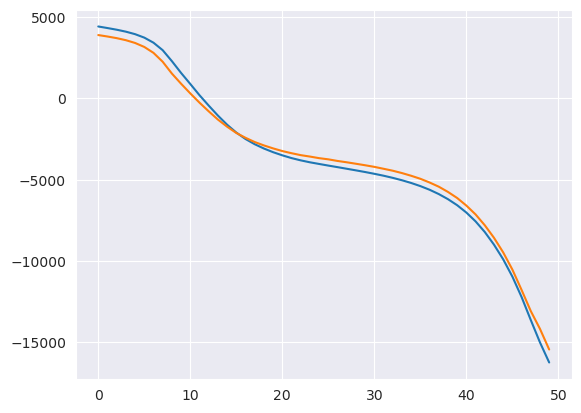

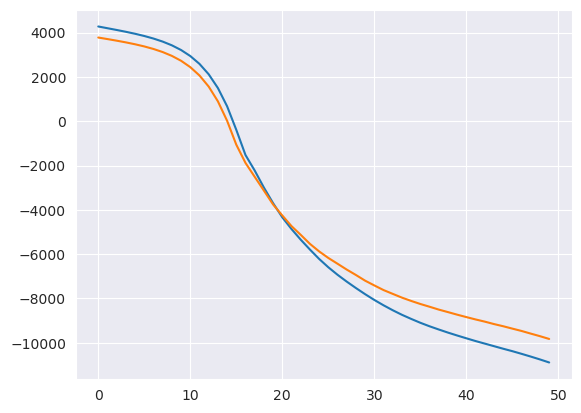

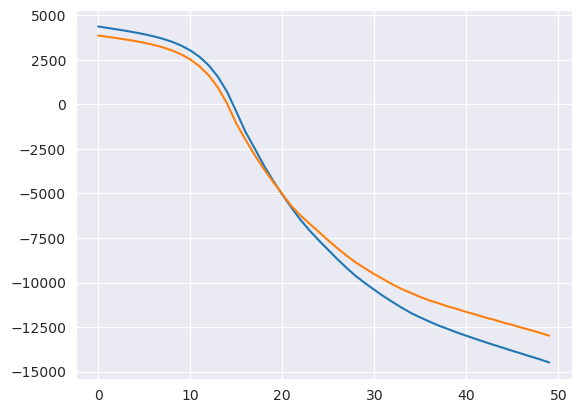

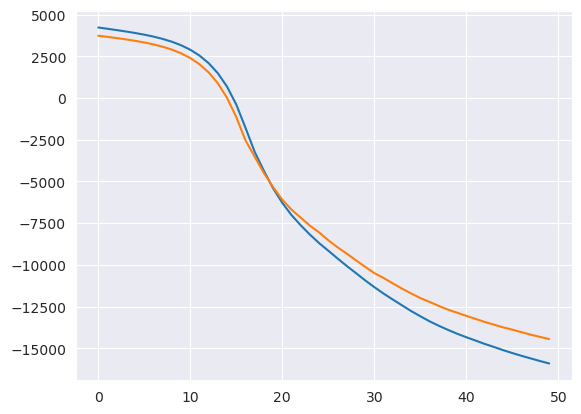

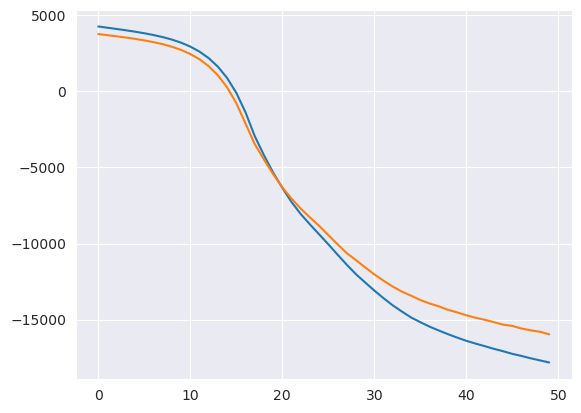

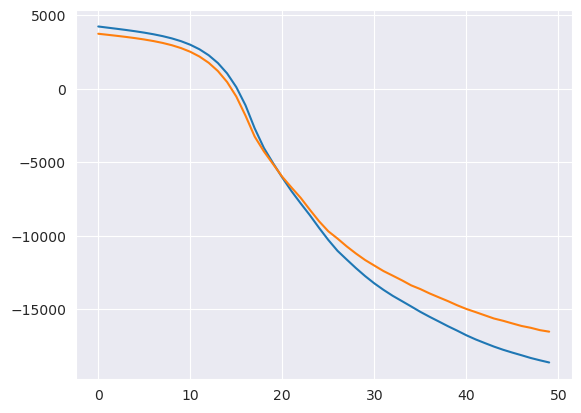

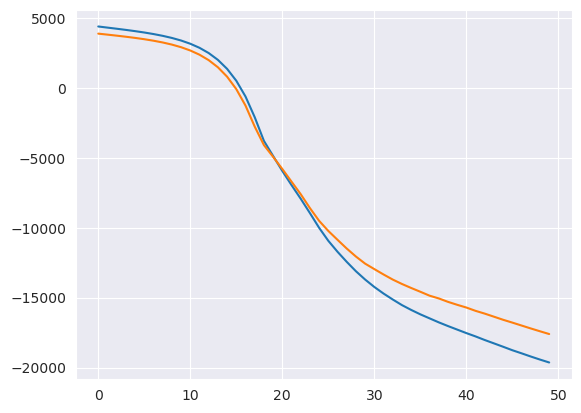

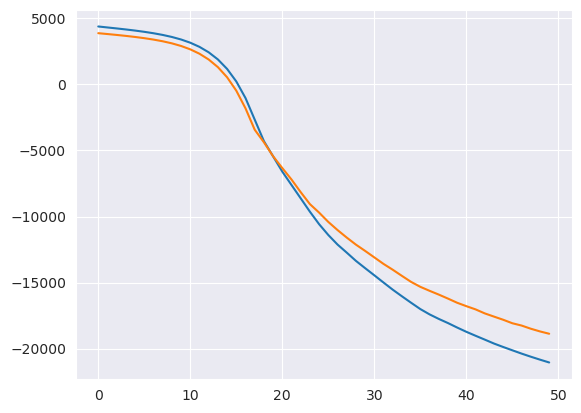

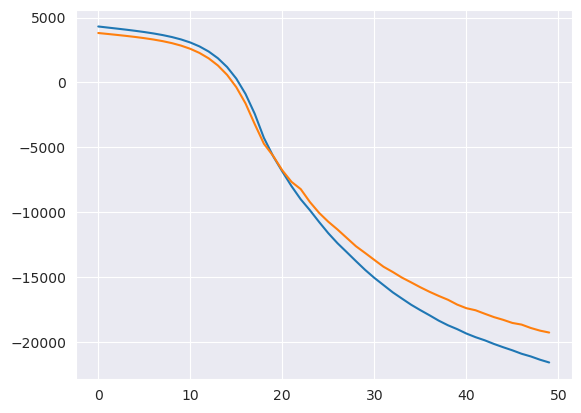

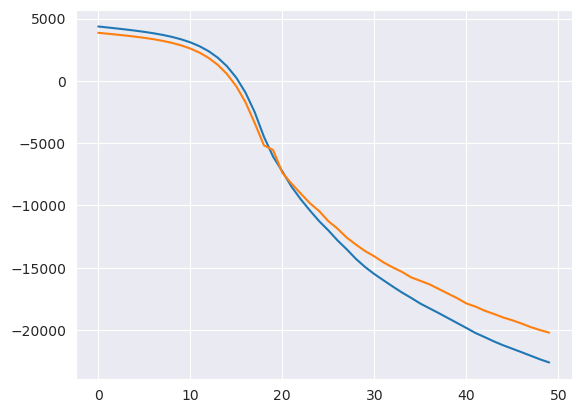

In [18]:
for i in range(10):
    plt.figure(i)  # Create a new figure for each plot
    plt.plot(np.array(loss_vals[i][0]))
    plt.plot(np.array(loss_vals[i][1]))
    plt.show()  # Display the plot

In [19]:
model_path = model_base_path/'hyperparameters.pkl'

with open(model_path, 'wb') as f:
    pickle.dump({'ncomps':ncomps, 'nevecs':nevecs,'nbasecomps':nbasecomps, 'ncauses':ncauses, 'crop_size':crop_size}, f)

## Linear regression

In [20]:
import torch
import yaml
from utils.helpers import dict2namespace

with open(macaw_path/'config'/'ukbb.yaml', 'r') as f:
    config_raw = yaml.load(f, Loader=yaml.FullLoader)
    
config = dict2namespace(config_raw)
config.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [21]:
ed =  encoded_data[:,:nevecs]
X = np.hstack([sex[:,np.newaxis], bmi[:,np.newaxis], ed])    

NameError: name 'sex' is not defined

In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X, age)

In [ ]:
reg.score(X, age)

In [ ]:
lr_path = model_base_path/'lr.pkl'

with open(lr_path, 'wb') as f:
    pickle.dump({'reg':reg}, f)

In [ ]:
lr_path

In [ ]:
reg.coef_

In [ ]:
np.mean(np.abs(reg.predict(X) - age))

In [ ]:
idx = 0
macaw = torch.load(model_base_path/f'{idx}.pt')
X_test = np.hstack([sex[:,np.newaxis], age[:,np.newaxis], bmi[:,np.newaxis], encoded_data[:,idx:nevecs+idx]])

In [ ]:
encoded_data.shape

In [ ]:
probs=[]
for i in range(36):
    X_test[:,1] = i
    probs.append(macaw.log_likelihood(X_test))

In [ ]:
pexp = np.exp(np.array(probs))
pexp_sum = np.sum(pexp,axis=0)
p = pexp/pexp_sum

In [ ]:
pred_labels = np.argmax(probs, axis=0)

In [ ]:
age_bins=36

In [ ]:
sns.histplot(age, bins=age_bins)
sns.histplot(pred_labels,bins=age_bins)

In [ ]:
l = np.array(probs)[:,80]
plt.bar(np.arange(36),l-np.min(l))

In [ ]:
sns.histplot(age-pred_labels, bins=age_bins)

In [ ]:
np.mean(np.abs(pred_labels - age))